In [1]:
%matplotlib inline
import sys
sys.path.append('/home/igr/src/model/nengo_maze_env')
from functools import partial
import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nengo_dl
from prf_net import PRF
from tqdm import tqdm
import scipy.interpolate
from scipy.interpolate import Rbf, PchipInterpolator, Akima1DInterpolator

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module '_yaml' does not match runtime version 3.6
  return f(*args, **kwds)
/home/igr/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/igr/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/igr/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be unde

In [2]:
#download mnist dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()

#flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))


In [3]:
with nengo.Network(seed = 0) as auto_net:
    auto_net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([40])
    auto_net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    auto_net.config[nengo.Connection].synapse = None # this disables synaptic filtering

    # n_type = nengo.PoissonSpiking(nengo.RectifiedLinear())
    # n_type = nengo.RectifiedLinear()
    n_type = nengo.SpikingRectifiedLinear() 

    n_in = 784
    inter_dim = 128

    inp_node = nengo.Node(np.zeros(n_in))

    # first layer
    enc1 = nengo.Ensemble(inter_dim, 1, neuron_type = n_type)
    nengo.Connection(inp_node, enc1.neurons, transform=nengo_dl.dists.Glorot())

    # second layer
    enc2 = nengo.Ensemble(inter_dim, 1, neuron_type = n_type)
    nengo.Connection(enc1.neurons, enc2.neurons, transform=nengo_dl.dists.Glorot())

    # output layer
    outp = nengo.Ensemble(n_in, 1, neuron_type=n_type)
    nengo.Connection(enc2.neurons, outp.neurons, transform=nengo_dl.dists.Glorot())

    # probes
    p_c = nengo.Probe(outp.neurons)
    p_c_filt = nengo.Probe(outp.neurons, synapse=0.01, label="out_p_filt")
    p_enc1 = nengo.Probe(enc1.neurons, synapse=None, label="enc1_p")
    p_enc2 = nengo.Probe(enc2.neurons, synapse=None, label="enc2_p")
    
    # from mnist example
    # out_p = nengo.Probe(outp, label="out_p")
    # out_p_filt = nengo.Probe(outp, synapse=0.1, label="out_p_filt")



In [4]:
minibatch_size = 50

with nengo_dl.Simulator(network=auto_net, minibatch_size=minibatch_size) as sim:
  sim.predict(np.ones((minibatch_size, 1, n_in)));

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|             Constructing graph: build stage (0%)             | ETA:  --:--:--

/home/igr/.local/lib/python3.6/site-packages/nengo_dl/simulator.py:467: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  "No GPU support detected. See "


Construction finished in 0:00:00                                               
|##############Constructing graph: build stage (64%)             | ETA: 0:00:00

/home/igr/.local/lib/python3.6/site-packages/nengo_dl/simulator.py:1030: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  "Running for one timestep, but the network contains "


In [5]:
# changing the model to more closely match how tensorflow works

for ens in auto_net.all_ensembles:
  ens.gain = nengo.dists.Choice([1]) # set all gains to 1
  ens.bias = nengo.dists.Choice([0]) # set all biases to 0 

# disables synaptic filtering.. eventually we want to use it though
for conn in auto_net.all_connections:
  conn.synapse = None 

In [6]:
# reshaping the data again for use in simulation, since with spiking networks simulations are temporal
# shape: (batch_size, n_steps, n)

train_data = train_data[:, None, :]

# # when testing our network with spiking neurons we will need to run it 
# # over time, so we repeat the input/target data for a number of 
# # timesteps.

n_steps = 300
test_data = np.tile(test_data[:, None, :], (1, n_steps, 1))


In [39]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
  sim.compile(optimizer = tf.optimizers.RMSprop(1e-3), 
              loss = {#p_c: tf.losses.mse, # mean squared error as loss function
                      p_c: tf.losses.kullback_leibler_divergence, 
                      p_c_filt: None}
             ) 

  # run training loop. If using spiking neurons, this converts the model to a rate based approximation and then does training
  sim.fit(train_data, train_data, epochs = 10)
  sim.freeze_params(auto_net)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/10
1200/1200 [==============================] - 110s 91ms/step - loss: 2372.4248 - probe_loss: 2372.4248
Epoch 2/10
1200/1200 [==============================] - 107s 89ms/step - loss: 2369.4265 - probe_loss: 2369.4265
Epoch 3/10
1200/1200 [==============================] - 110s 92ms/step - loss: 2368.4390 - probe_loss: 2368.4390
Epoch 4/10
1200/1200 [==============================] - 109s 91ms/step - loss: 2368.1304 - probe_loss: 2368.1304
Epoch 5/10
1200/1200 [==============================] - 108s 90ms/step - loss: 2368.0173 - probe_loss: 2368.0173
Epoch 6/10
1200/1200 [==============================] - 109s 91ms/step - loss: 2367.9946 - probe_loss: 2367.9946
Epoch 7/10
1200/1200 [==============================] - 109s 91ms/step - loss: 236

In [41]:
for conn in auto_net.all_connections:
    conn.synapse = 0.005

with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:


  sim.compile(optimizer = tf.optimizers.RMSprop(1e-3), 
              loss = {#p_c: tf.losses.mse, # mean squared error as loss function
                      p_c: tf.losses.kullback_leibler_divergence, 
                      p_c_filt: None}
             )
  # evaluate performance on test set
  print("Test error: ", sim.evaluate(test_data, {p_c: test_data}))

  # display example output
  output = sim.predict(test_data[:minibatch_size]) # runs sim.predict on the first minibatch of the data 
 

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
200/200 [==============================] - 2285s 11s/step - loss: 2097.5405 - probe_loss: 2097.5405
Test error:  OrderedDict([('loss', 2097.54052734375), ('probe_loss', 2097.54052734375)])


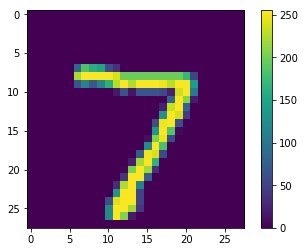

In [42]:

plt.figure()
plt.imshow(test_data[0, 99].reshape((28,28)), interpolation="nearest", aspect="equal")
plt.colorbar()

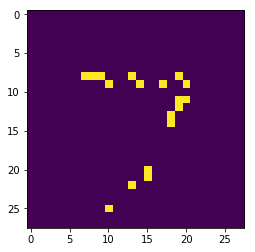

In [43]:
plt.figure()
plt.imshow(output[p_c][0, 99].reshape((28, 28)))


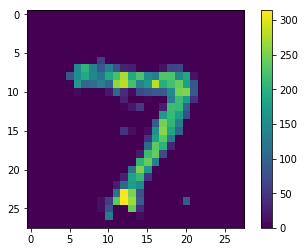

In [44]:
plt.figure()
plt.imshow(output[p_c_filt][0, 99].reshape((28, 28)))
plt.colorbar()


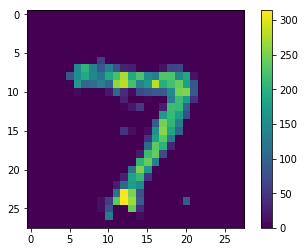

In [45]:
plt.figure()
plt.imshow(output[p_c_filt][0, 99].reshape((28, 28)))
plt.colorbar()


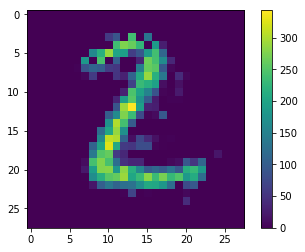

In [46]:
plt.figure()
plt.imshow(output[p_c_filt][1, 99].reshape((28, 28)))
plt.colorbar()


In [47]:
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance, sample_by_activity)
from nengo_extras.neurons import (
    rates_kernel, rates_isi )

(15000, 128)
(15000,)
232114
(15000, 128)


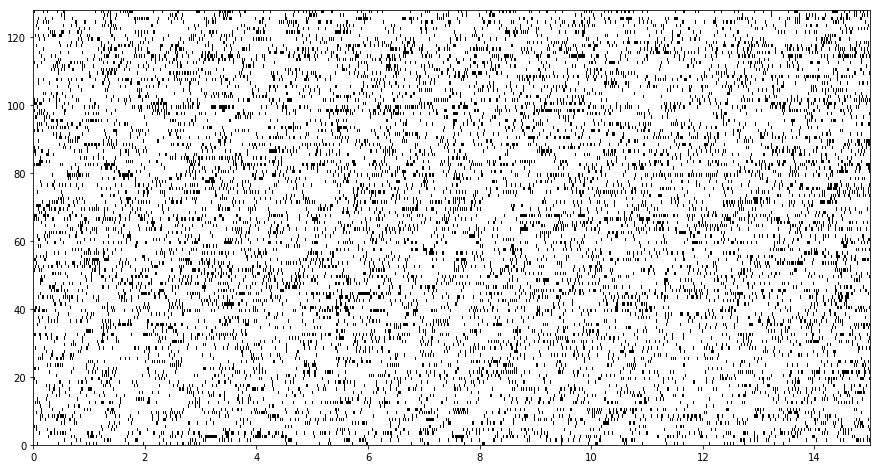

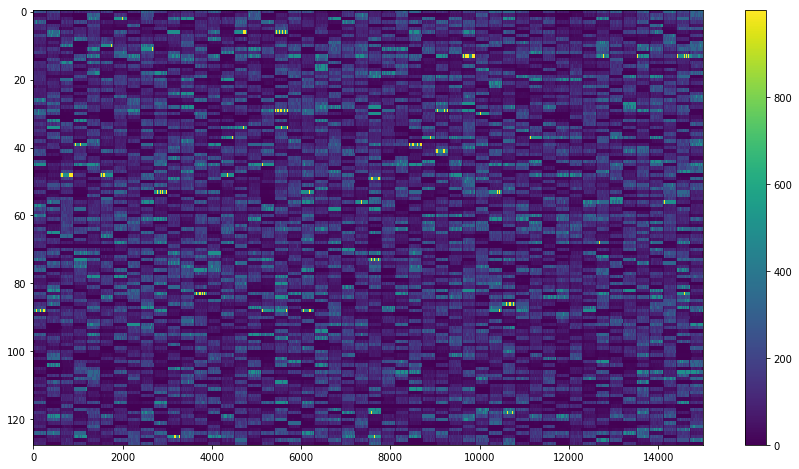

In [48]:
dt = 0.001
enc2_spikes = output[p_enc2].reshape((-1,128))
trange = np.linspace(0, enc2_spikes.shape[0]*dt, enc2_spikes.shape[0])
print(enc2_spikes.shape)
print(trange.shape)
plt.figure(figsize=(15,8))
plot_spikes(trange, enc2_spikes);

enc2_output = np.asarray(enc2_spikes * dt, dtype=np.uint8)

print(np.sum(enc2_output))
plt.figure(figsize=(15,8))
enc2_rates = rates_isi(trange, enc2_spikes)
print(enc2_rates.shape)
plt.imshow(enc2_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();


In [49]:

n_trials = 3

encoded_inputs = enc2_output*2
t_test = encoded_inputs.shape[0]
input_time_array = np.linspace(0, t_test*n_trials*dt, encoded_inputs.shape[0]*n_trials)
input_matrix = np.tile(encoded_inputs, (n_trials, 1))
input_matrix.shape
np.save("srf_nengo_autoencoder_input_matrix", np.asarray(input_matrix, dtype=np.float32))


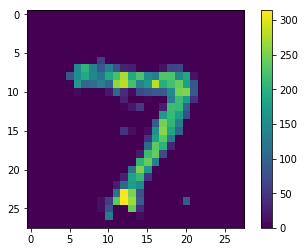

In [50]:
plt.figure()
plt.imshow(output[p_c_filt][0, 99].reshape((28, 28)))
plt.colorbar()


In [51]:
encoded_inputs[:100, 0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0], dtype=uint8)

In [52]:
def array_input(input_matrix, dt, t, *args):
    i = int(t/dt)
    if i >= input_matrix.shape[0]:
        i = -1
    return input_matrix[i,:]

In [53]:
N_Outputs = 100
N_Exc = inter_dim
N_Inh = int(inter_dim/4)

srf_seed = 19
srf_network = PRF(exc_input_func = partial(array_input, input_matrix, dt),
                  connect_exc_inh_input = True,
                  n_excitatory = N_Exc,
                  n_inhibitory = N_Inh,
                  n_outputs = N_Outputs,
                  w_initial_E = 2e-2,
                  w_initial_I = -6e-2,
                  w_initial_EI = 5e-3,
                  w_EI_Ext = 5e-4,
                  p_EI_Ext = 0.25,
                  p_E = 0.1,
                  p_EE = 0.05,
                  tau_E = 0.01,
                  tau_I = 0.03,
                  tau_input = 0.5,
                  isp_target_rate = 1.0,
                  learning_rate_I=1e-4,
                  learning_rate_E=1e-4,
                  #earning_rate_EE=1e-4,
                  label="Spatial receptive field network",
                  seed=srf_seed)



In [54]:
t_end = np.max(input_time_array)
with srf_network:
    p_output_spikes = nengo.Probe(srf_network.output.neurons, 'spikes', synapse=None)
    p_exc_rates = nengo.Probe(srf_network.exc.neurons, 'rates')
    p_inh_rates = nengo.Probe(srf_network.inh.neurons, 'rates')
    p_inh_weights = nengo.Probe(srf_network.conn_I, 'weights')
    p_exc_weights = nengo.Probe(srf_network.conn_E, 'weights')
    if srf_network.conn_EE is not None:
        p_rec_weights = nengo.Probe(srf_network.conn_EE, 'weights')
        
with nengo.Simulator(srf_network, optimize=True) as sim:
    sim.run(np.max(t_end))
    


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [28]:
output_spikes = sim.data[p_output_spikes]
np.save("srf_output_spikes", np.asarray(output_spikes, dtype=np.float32))
np.save("srf_time_range", np.asarray(sim.trange(), dtype=np.float32))

exc_rates = sim.data[p_exc_rates]
inh_rates = sim.data[p_inh_rates] 

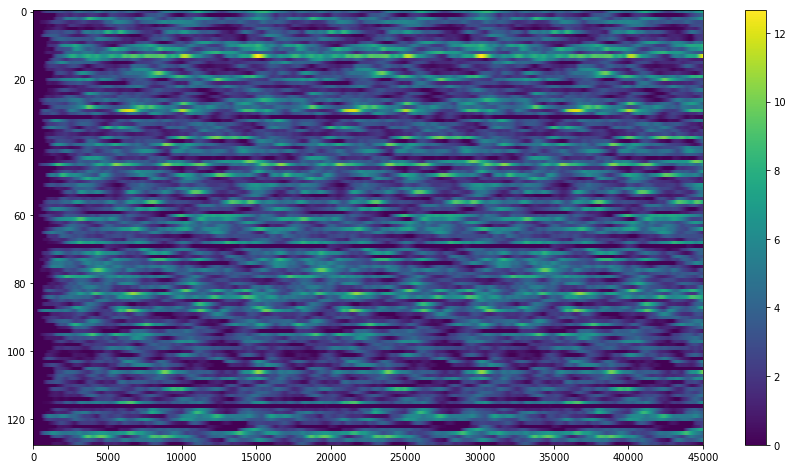

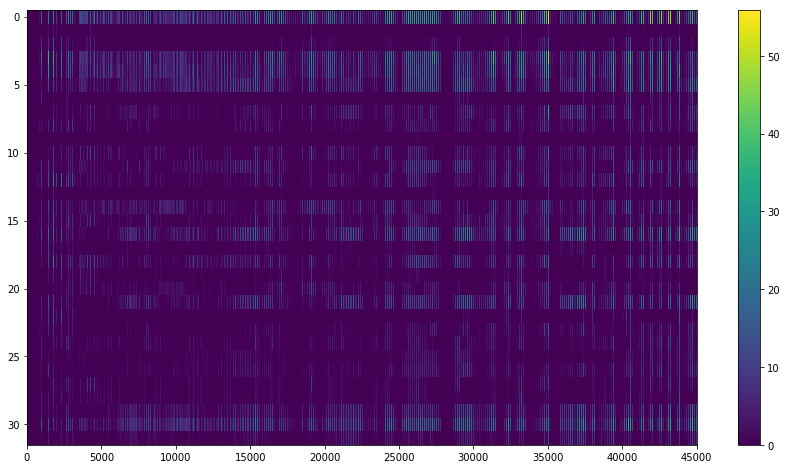

In [29]:
plt.figure(figsize=(15,8))
plt.imshow(exc_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();

plt.figure(figsize=(15,8))
plt.imshow(inh_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();


2856142.151099508
0.6346982557998907


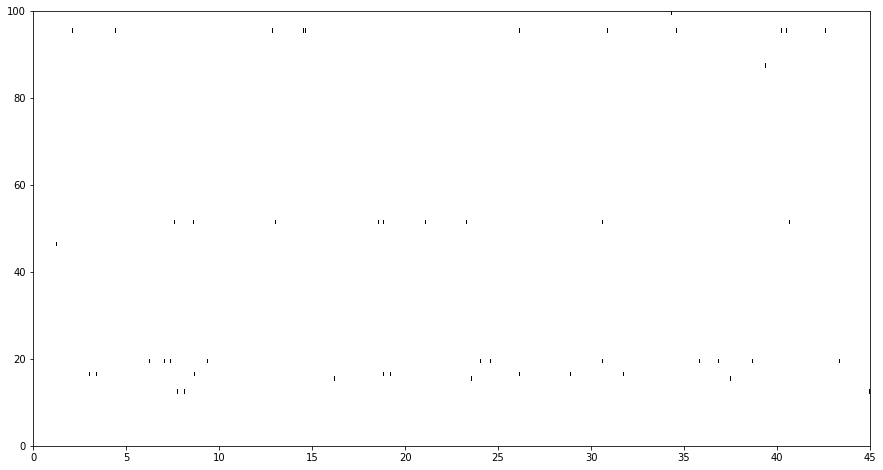

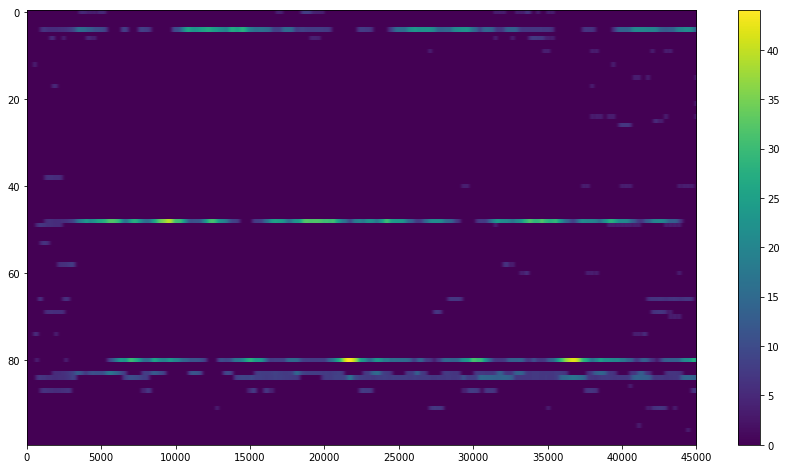

In [37]:
plt.figure(figsize=(15,8))
plot_spikes(sim.trange(), output_spikes)

output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.25)
print(np.sum(output_rates))
print(np.mean(output_rates))
plt.figure(figsize=(15,8))
plt.imshow(output_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();


30000


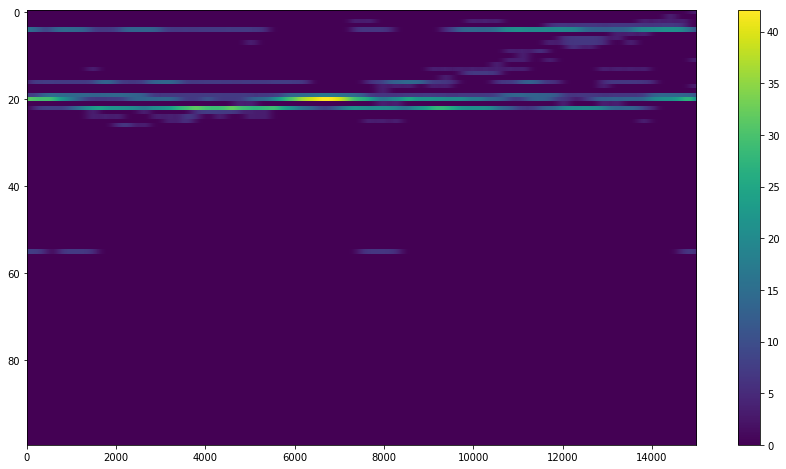

In [36]:
last_trial_start = int(t_test*(n_trials-1))
print(last_trial_start)
sorted_idxs = np.argsort(-np.argmax(output_rates[last_trial_start:,:].T, axis=1))
plt.figure(figsize=(15,8))
plt.imshow(output_rates[last_trial_start:,sorted_idxs].T, interpolation="nearest", aspect="auto")
plt.colorbar();
